In [1]:
import torch
import torch.nn as nn

In [8]:
off_diag_elems = torch.randn(3, 4-1)
diag_elems = torch.randn(3, 4)

In [9]:
# fill elements
prec = torch.diag_embed(diag_elems) + torch.diag_embed(off_diag_elems, offset=1, dim1=-2, dim2=-1)
# take product of transpose
prec1 = torch.bmm(prec.transpose(1, 2), prec)# + eps * torch.eye(prec.shape[-1], device=prec.device)

In [10]:
batch, time = diag_elems.shape
device = diag_elems.device
prec2 = torch.zeros(batch, time, time, device=device)
a_2 = diag_elems**2
b_2 = torch.cat([torch.zeros(batch, 1, device=device), off_diag_elems**2], dim=1)
ab = diag_elems[:, :-1] * off_diag_elems            
prec2 += torch.diag_embed(a_2+b_2, dim1=-2, dim2=-1)
off_diagonal = torch.diag_embed(ab, offset=1, dim1=-2, dim2=-1)            
prec2 += off_diagonal + off_diagonal.transpose(-2, -1)

In [11]:
# check diff between prec1 and prec2
print(torch.norm(prec1 - prec2))

tensor(0.)


In [ ]:
l = 100
d = 5
mu1 = torch.zeros(l, d)
sigma1 = torch.eye(d, d).repeat(l, 1, 1)
mu = torch.randn(l, d)
A = torch.tril(torch.randn(l, d, d))
# make diagonal positive
diag = torch.diagonal(A, dim1=-2, dim2=-1)        
diag = nn.Softplus()(diag)
# set diag of A to diag
A = A - torch.diag_embed(torch.diagonal(A, dim1=-2, dim2=-1)) + torch.diag_embed(diag)

In [ ]:
p = torch.distributions.MultivariateNormal(mu1, scale_tril=sigma1)
q = torch.distributions.MultivariateNormal(mu, scale_tril=A)
# compute the kl divergence
kl_loss = torch.distributions.kl_divergence(q, p).sum()
print(kl_loss)

In [ ]:
cov = torch.bmm(A, torch.transpose(A, 1, 2))
det = torch.det(cov)
kl_loss = 0.5 * torch.sum(torch.sum(mu.pow(2), dim=1) + torch.einsum("...ii", cov) - mu.shape[1] - torch.log(det))
print(kl_loss, 'original')

In [ ]:
batch, dim, time = 10, 5, 100
bd = torch.randn(batch, time, 2*dim)
prec = torch.zeros(batch, dim, time, time)
for i in range(dim):
    diag_elems = bd[:, :, i]
    off_diag_elems = bd[:, :-1, i+dim]
    # fill elements
    prec[:, i, :, :] = torch.diag_embed(diag_elems) + torch.diag_embed(off_diag_elems, offset=1, dim1=-2, dim2=-1)
    prec[:, i, :, :] = torch.bmm(prec[:, i, :, :].transpose(1, 2), prec[:, i, :, :])
    print(prec[0, i, :, :])

In [2]:
from vae_unimodal import TimeSeries

In [9]:
a = TimeSeries(10, 8, 2, 25, False, 1, False, 0.1)

In [10]:
y = torch.randn(5, 25, 10)

In [17]:
out = a.forward(y)
out[0].sample_n(10).shape

/Users/mithileshvaidya/miniforge3/lib/python3.10/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


torch.Size([10, 5, 25])

In [9]:
# create matrix with 1 on diagonala and off diagonal
a = torch.eye(5, 5)
# put 1 on off diagonal
a += torch.diag_embed(torch.ones(4), 1)
# print(a.T @ a)
print(torch.linalg.inv(a.T @ a))

tensor([[ 5., -4.,  3., -2.,  1.],
        [-4.,  4., -3.,  2., -1.],
        [ 3., -3.,  3., -2.,  1.],
        [-2.,  2., -2.,  2., -1.],
        [ 1., -1.,  1., -1.,  1.]])


tensor([[1.0000e+00, 9.8020e-01, 9.2312e-01, 8.3527e-01, 7.2615e-01, 6.0653e-01,
         4.8675e-01, 3.7531e-01, 2.7804e-01, 1.9790e-01, 1.3534e-01, 8.8922e-02,
         5.6135e-02, 3.4047e-02, 1.9841e-02, 1.1109e-02, 5.9760e-03, 3.0887e-03,
         1.5338e-03, 7.3180e-04, 3.3546e-04, 1.4775e-04, 6.2521e-05, 2.5419e-05,
         9.9295e-06],
        [9.8020e-01, 1.0000e+00, 9.8020e-01, 9.2312e-01, 8.3527e-01, 7.2615e-01,
         6.0653e-01, 4.8675e-01, 3.7531e-01, 2.7804e-01, 1.9790e-01, 1.3534e-01,
         8.8922e-02, 5.6135e-02, 3.4047e-02, 1.9841e-02, 1.1109e-02, 5.9760e-03,
         3.0887e-03, 1.5338e-03, 7.3180e-04, 3.3546e-04, 1.4775e-04, 6.2521e-05,
         2.5419e-05],
        [9.2312e-01, 9.8020e-01, 1.0000e+00, 9.8020e-01, 9.2312e-01, 8.3527e-01,
         7.2615e-01, 6.0653e-01, 4.8675e-01, 3.7531e-01, 2.7804e-01, 1.9790e-01,
         1.3534e-01, 8.8922e-02, 5.6135e-02, 3.4047e-02, 1.9841e-02, 1.1109e-02,
         5.9760e-03, 3.0887e-03, 1.5338e-03, 7.3180e-04, 3.3546e-

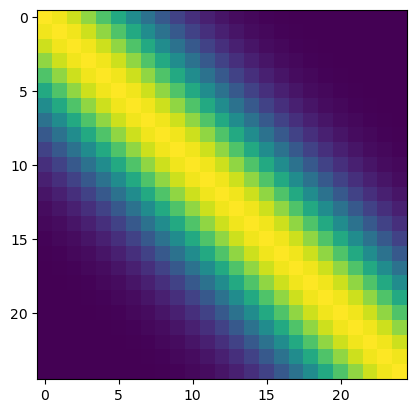

In [17]:
from vae_gp import rbf_kernel
import matplotlib.pyplot as plt
a = rbf_kernel(25, 5) + 1e-6 * torch.eye(25)
plt.imshow(a)
# cholesky decomposition
L = torch.cholesky(a)

In [3]:
from vae_gp_combined import CustomDistribution
import torch.distributions as dist
import torch

In [9]:
m, a = torch.randn(5, 10), torch.randn(5, 10, 10)
a = CustomDistribution(m, a)
print(a.kl_divergence_normal())

tensor(215.5961)


In [10]:
d = dist.MultivariateNormal(m, covariance_matrix=a.get_covariance_matrix())

In [11]:
print(dist.kl_divergence(d, dist.MultivariateNormal(torch.zeros(5, 10), torch.eye(10))).sum())

tensor(215.5961)
